## Abstract

This notebook investigates **physics-informed machine learning approaches for charged particle trajectory prediction** using **CMS Open Data**. The goal is to study trajectory continuation as a supervised learning problem while preserving the underlying physical constraints imposed by motion in a magnetic field.

Using collision data from the CMS experiment in ROOT format, a controlled sample of muon kinematic parameters is extracted and used to generate synthetic, physics-consistent helical trajectories in the transverse plane. Rather than starting from detector-level images or hit information, this work focuses on an intermediate stage: learning to extrapolate particle motion from partial trajectory information under known physical laws.

The problem is formulated as a trajectory continuation regression task, where the first 
/[N/]
N points of a trajectory serve as input and the subsequent point as the prediction target. Emphasis is placed on scalable data handling, baseline modeling, and quantitative evaluation before introducing more complex learning architectures.

This staged approach provides a controlled environment to validate data pipelines, physics assumptions, and learning feasibility, and serves as a foundation for future extensions including noise modeling, missing measurements, three-dimensional motion, and detector-level representations.

### Scope and Assumptions

**Scope**
This study is intentionally scoped to isolate and validate the feasibility of **physics-informed trajectory prediction** before introducing detector-specific complexities or deep learning architectures.

* The analysis focuses on **charged muon trajectories** derived from **CMS Open Data**.
* Trajectory modeling is performed in **3D space**, utilizing cylindrical symmetry common in collider physics.
* Particle motion is generated using a **forward physics model** based on helical motion in a uniform magnetic field.
* The machine learning task is limited to **trajectory continuation**, formulated as a supervised regression problem.
* Only **baseline models** (Linear Regression and Random Forest) are considered at this stage to establish performance benchmarks.
* Data handling and dataset construction are designed to be **streaming and memory-safe**, enabling scalability to large datasets.

**Assumptions**
* The CMS magnetic field is assumed to be **uniform and constant** (3.8T) within the region of interest.
* Energy loss, multiple scattering, and detector material interactions are neglected.
* Detector resolution effects (Gaussian noise) are not modeled, though **spatial sparsity** is introduced to simulate detector layers.
* Trajectories are analytically generated using **kinematic parameters ($p_T, \eta, \phi, q$) sampled from real/simulated data**.
* The learning task assumes access to **ordered trajectory points** without ambiguity in point association.

These assumptions allow for controlled validation of data pipelines, physical consistency, and baseline learning behavior. Relaxing these assumptions and introducing detector-level effects is deferred to subsequent stages of the project.

## Requirement

In [3]:
!pip install uproot awkward numpy matplotlib scikit-learn tqdm -q
import sys
import numpy as np
import pandas as pd
import awkward as ak
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import awkward as ak
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
print("Python:", sys.version)
print("NumPy:", np.__version__)

Python: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]
NumPy: 1.26.4


In [13]:
file = uproot.open("/home/jupyter/work/data/cms.root")
events = file["Events;75"]


events.keys()

['nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge']

## Exploratory Data Analysis

In [15]:
def sample_muons_chunked(file_path, max_muons=1_000_000, chunk_size=1_000_000):
    """
    Stream through CMS events in chunks, collect up to max_muons muons.
    Returns NumPy arrays (pt, eta, phi, charge).
    """
    
    pt_out, eta_out, phi_out, charge_out = [], [], [], []
    collected = 0
    
    with uproot.open(file_path) as file:
        tree = file["Events"]
        branches = ["Muon_pt", "Muon_eta", "Muon_phi", "Muon_charge"]
                    
        for arrays in tree.iterate(branches, step_size=chunk_size, library="ak"):
            pt_flat = ak.flatten(arrays["Muon_pt"])
            eta_flat = ak.flatten(arrays["Muon_eta"])
            phi_flat = ak.flatten(arrays["Muon_phi"])
            charge_flat = ak.flatten(arrays["Muon_charge"])
                    
            to_take = min(len(pt_flat), max_muons - collected)
            if to_take <= 0:
                break
            pt_out.append(pt_flat[:to_take])
            eta_out.append(eta_flat[:to_take])
            phi_out.append(phi_flat[:to_take])
            charge_out.append(charge_flat[:to_take])
                    
            collected += to_take
            if collected >= max_muons:
                break        
                    
    return (
        ak.to_numpy(ak.concatenate(pt_out)),
        ak.to_numpy(ak.concatenate(eta_out)),
        ak.to_numpy(ak.concatenate(phi_out)),
        ak.to_numpy(ak.concatenate(charge_out)).astype(np.int8)
    )
                    
# Usage
file_path = "/home/jupyter/work/data/cms.root"
pt_s, eta_s, phi_s, charge_s = sample_muons_chunked(file_path, max_muons=20_000)

print(len(pt_s))
print("pt range:", pt_s.min(), pt_s.max())
print("pt range:", eta_s.min(), eta_s.max())
print("phi range:", phi_s.min(), phi_s.max())
print("charges:", np.unique(charge_s))

20000
pt range: 3.000851 4139.4663
pt range: -3.2530193 3.571902
phi range: -3.1412365 3.1412053
charges: [-1  1]


Stats:
                 pt           eta           phi        charge
count  20000.000000  20000.000000  20000.000000  20000.000000
mean      17.500841      0.023015     -0.019635      0.008200
std       44.161701      1.255530      1.815387      0.999991
min        3.000851     -3.253019     -3.141237     -1.000000
25%        8.369601     -0.951213     -1.619102     -1.000000
50%       13.103428      0.024798     -0.050439      1.000000
75%       20.128166      0.997590      1.568570      1.000000
max     4139.466309      3.571902      3.141205      1.000000

Correlation Matrix:
              pt       eta       phi    charge
pt      1.000000 -0.007701 -0.002409  0.001688
eta    -0.007701  1.000000  0.008975  0.001552
phi    -0.002409  0.008975  1.000000  0.001693
charge  0.001688  0.001552  0.001693  1.000000


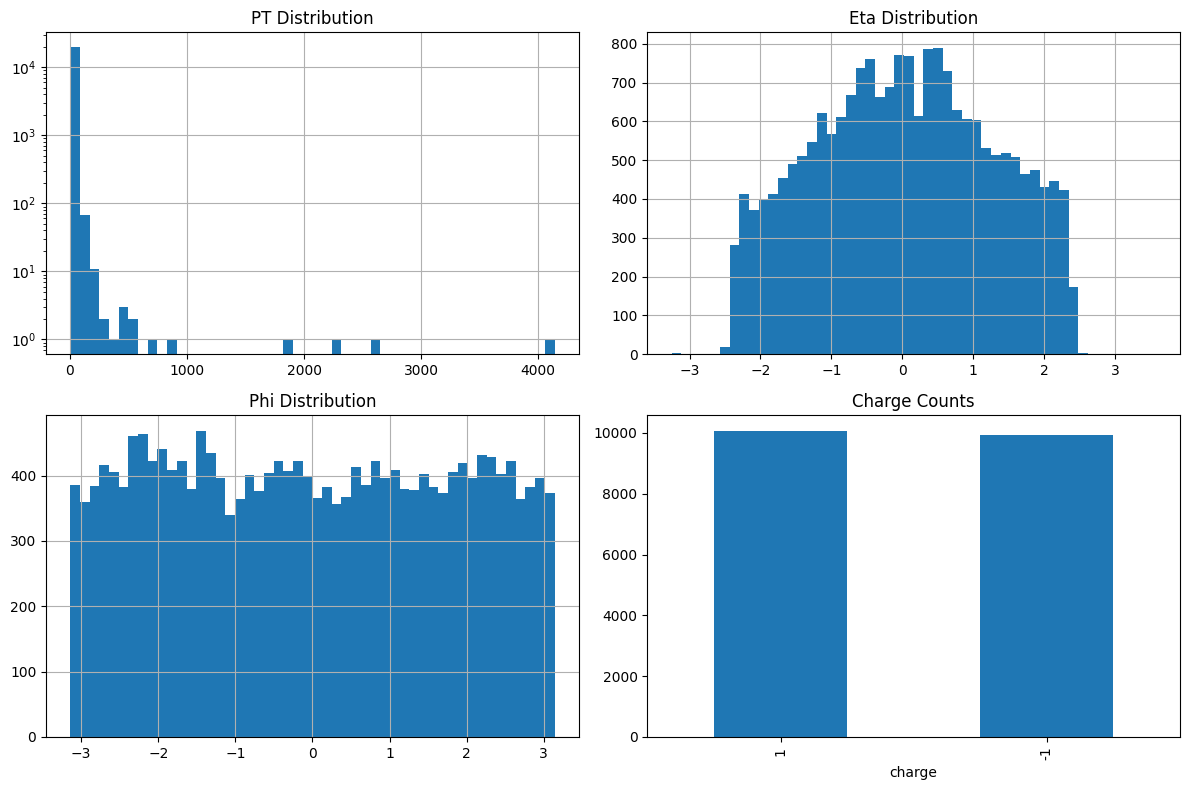

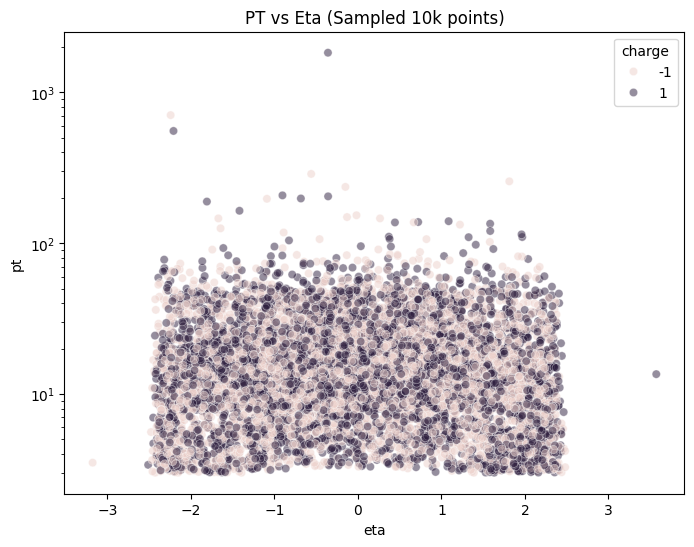

In [4]:
# DF

df = pd.DataFrame({
    'pt': pt_s,
    'eta': eta_s,
    'phi': phi_s,
    'charge': charge_s
})

# statistics

print("Stats:")
print(df.describe())

#Correlation Matrix

print("\nCorrelation Matrix:")
print(df.corr())

# Charts

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
df['pt'].hist(bins=50, ax=axes[0,0], log=True) #Log because of long tail
axes[0,0].set_title('PT Distribution')
df['eta'].hist(bins=50, ax=axes[0,1])
axes[0,1].set_title('Eta Distribution')
df['phi'].hist(bins=50, ax=axes[1,0])
axes[1,0].set_title('Phi Distribution')
df['charge'].value_counts().plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Charge Counts')
plt.tight_layout()
plt.show()

# Scatter Plot:

plt.figure(figsize=(8,6))
sns.scatterplot(x='eta', y='pt', hue='charge', data=df.sample(10000), alpha=0.5)  # Sample for speed
plt.title('PT vs Eta (Sampled 10k points)')
plt.yscale('log')
plt.show()


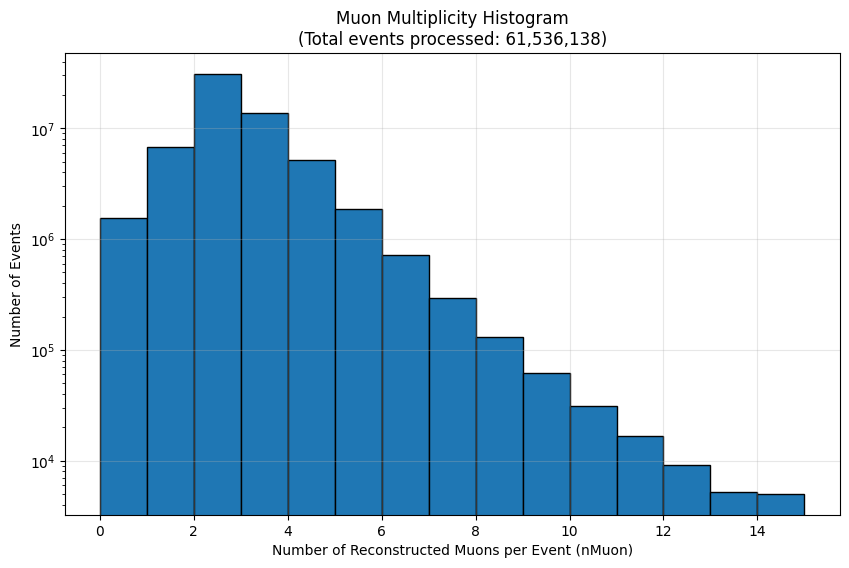

Multiplicity Table (muons per event):
nMuon | Events          | Percentage
------|-----------------|-----------
    0 |       1,550,682 |      2.52%
    1 |       6,718,485 |     10.92%
    2 |      31,104,343 |     50.55%
    3 |      13,823,608 |     22.46%
    4 |       5,193,919 |      8.44%
    5 |       1,882,447 |      3.06%
    6 |         712,735 |      1.16%
    7 |         291,275 |      0.47%
    8 |         129,914 |      0.21%
    9 |          61,748 |      0.10%
   10 |          31,103 |      0.05%
   11 |          16,577 |      0.03%
   12 |           9,071 |      0.01%
   13 |           5,196 |      0.01%
   14 |           5,035 |      0.01%
Total events: 61,536,138


In [10]:
def get_multiplicity_hist(file_path, chunk_size=1_000_000, max_bins=20):
    """
    Compute and plot muon multiplicity histogram efficiently (chunked).
    Handles Awkward to NumPy conversion safely.
    """

    hist = np.zeros(max_bins, dtype=np.int64)
    bins = np.arange(max_bins + 1)
    
    with uproot.open(file_path) as file:
        tree = file["Events"]
        for arrays in tree.iterate(["nMuon"], step_size=chunk_size, library="ak"):
            n_mu_per_event = arrays["nMuon"]  # Flat Awkward array of counts per even
            chunk_hist_ak, _ = np.histogram(n_mu_per_event, bins=bins)
            chunk_hist = ak.to_numpy(chunk_hist_ak)
            hist += chunk_hist
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(max_bins), hist, width=1, align='edge', edgecolor='black')
    plt.xlabel("Number of Reconstructed Muons per Event (nMuon)")
    plt.ylabel("Number of Events")
    plt.yscale("log")
    plt.title(f"Muon Multiplicity Histogram\n(Total events processed: {hist.sum():,})")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print table
    print("Multiplicity Table (muons per event):")
    print("nMuon | Events          | Percentage")
    print("------|-----------------|-----------")
    total = hist.sum()
    for i in range(max_bins):
        if hist[i] > 0:
            print(f"{i:5d} | {hist[i]:15,} | {100 * hist[i] / total:9.2f}%")
    print(f"Total events: {total:,}")

file_path = "work/data/cms.root"
get_multiplicity_hist(file_path, max_bins=15)

**Observation:** $p_T$ is power-law distributed (many low-energy muons), $\eta$ symmetric around **0** (detector coverage), $\phi$ uniform (-$\pi$ to $\pi$), charges balanced (**±1**). Multiplicity peaks at **2** (muon-enriched dataset)

## Visualisation (Physics)

In [19]:
# Helix Generator (Physics Engine)
def generate3dhelix(pt, eta, phi, charge, num_points=20, track_length=10.0):
    """ GEnerate 3d helical trajectory points for a muon using 20 points to reproduce realistic
    conditions of the detector sensors"""
    B = 3.8
    q = charge
    rho = pt / (0.3 * abs(q) * B)
    omega = -q * 0.3 * B / pt
    theta = 2 * np.arctan(np.exp(-eta))
    cot_theta = np.sinh(eta)
    max_alpha = track_length / rho
    alpha = np.linspace(0, max_alpha, num_points)
    x = rho * (np.cos(phi + omega * alpha) - np.cos(phi))
    y = rho * (np.sin(phi + omega * alpha) - np.sin(phi))
    z = rho * cot_theta * alpha
    return x, y, z

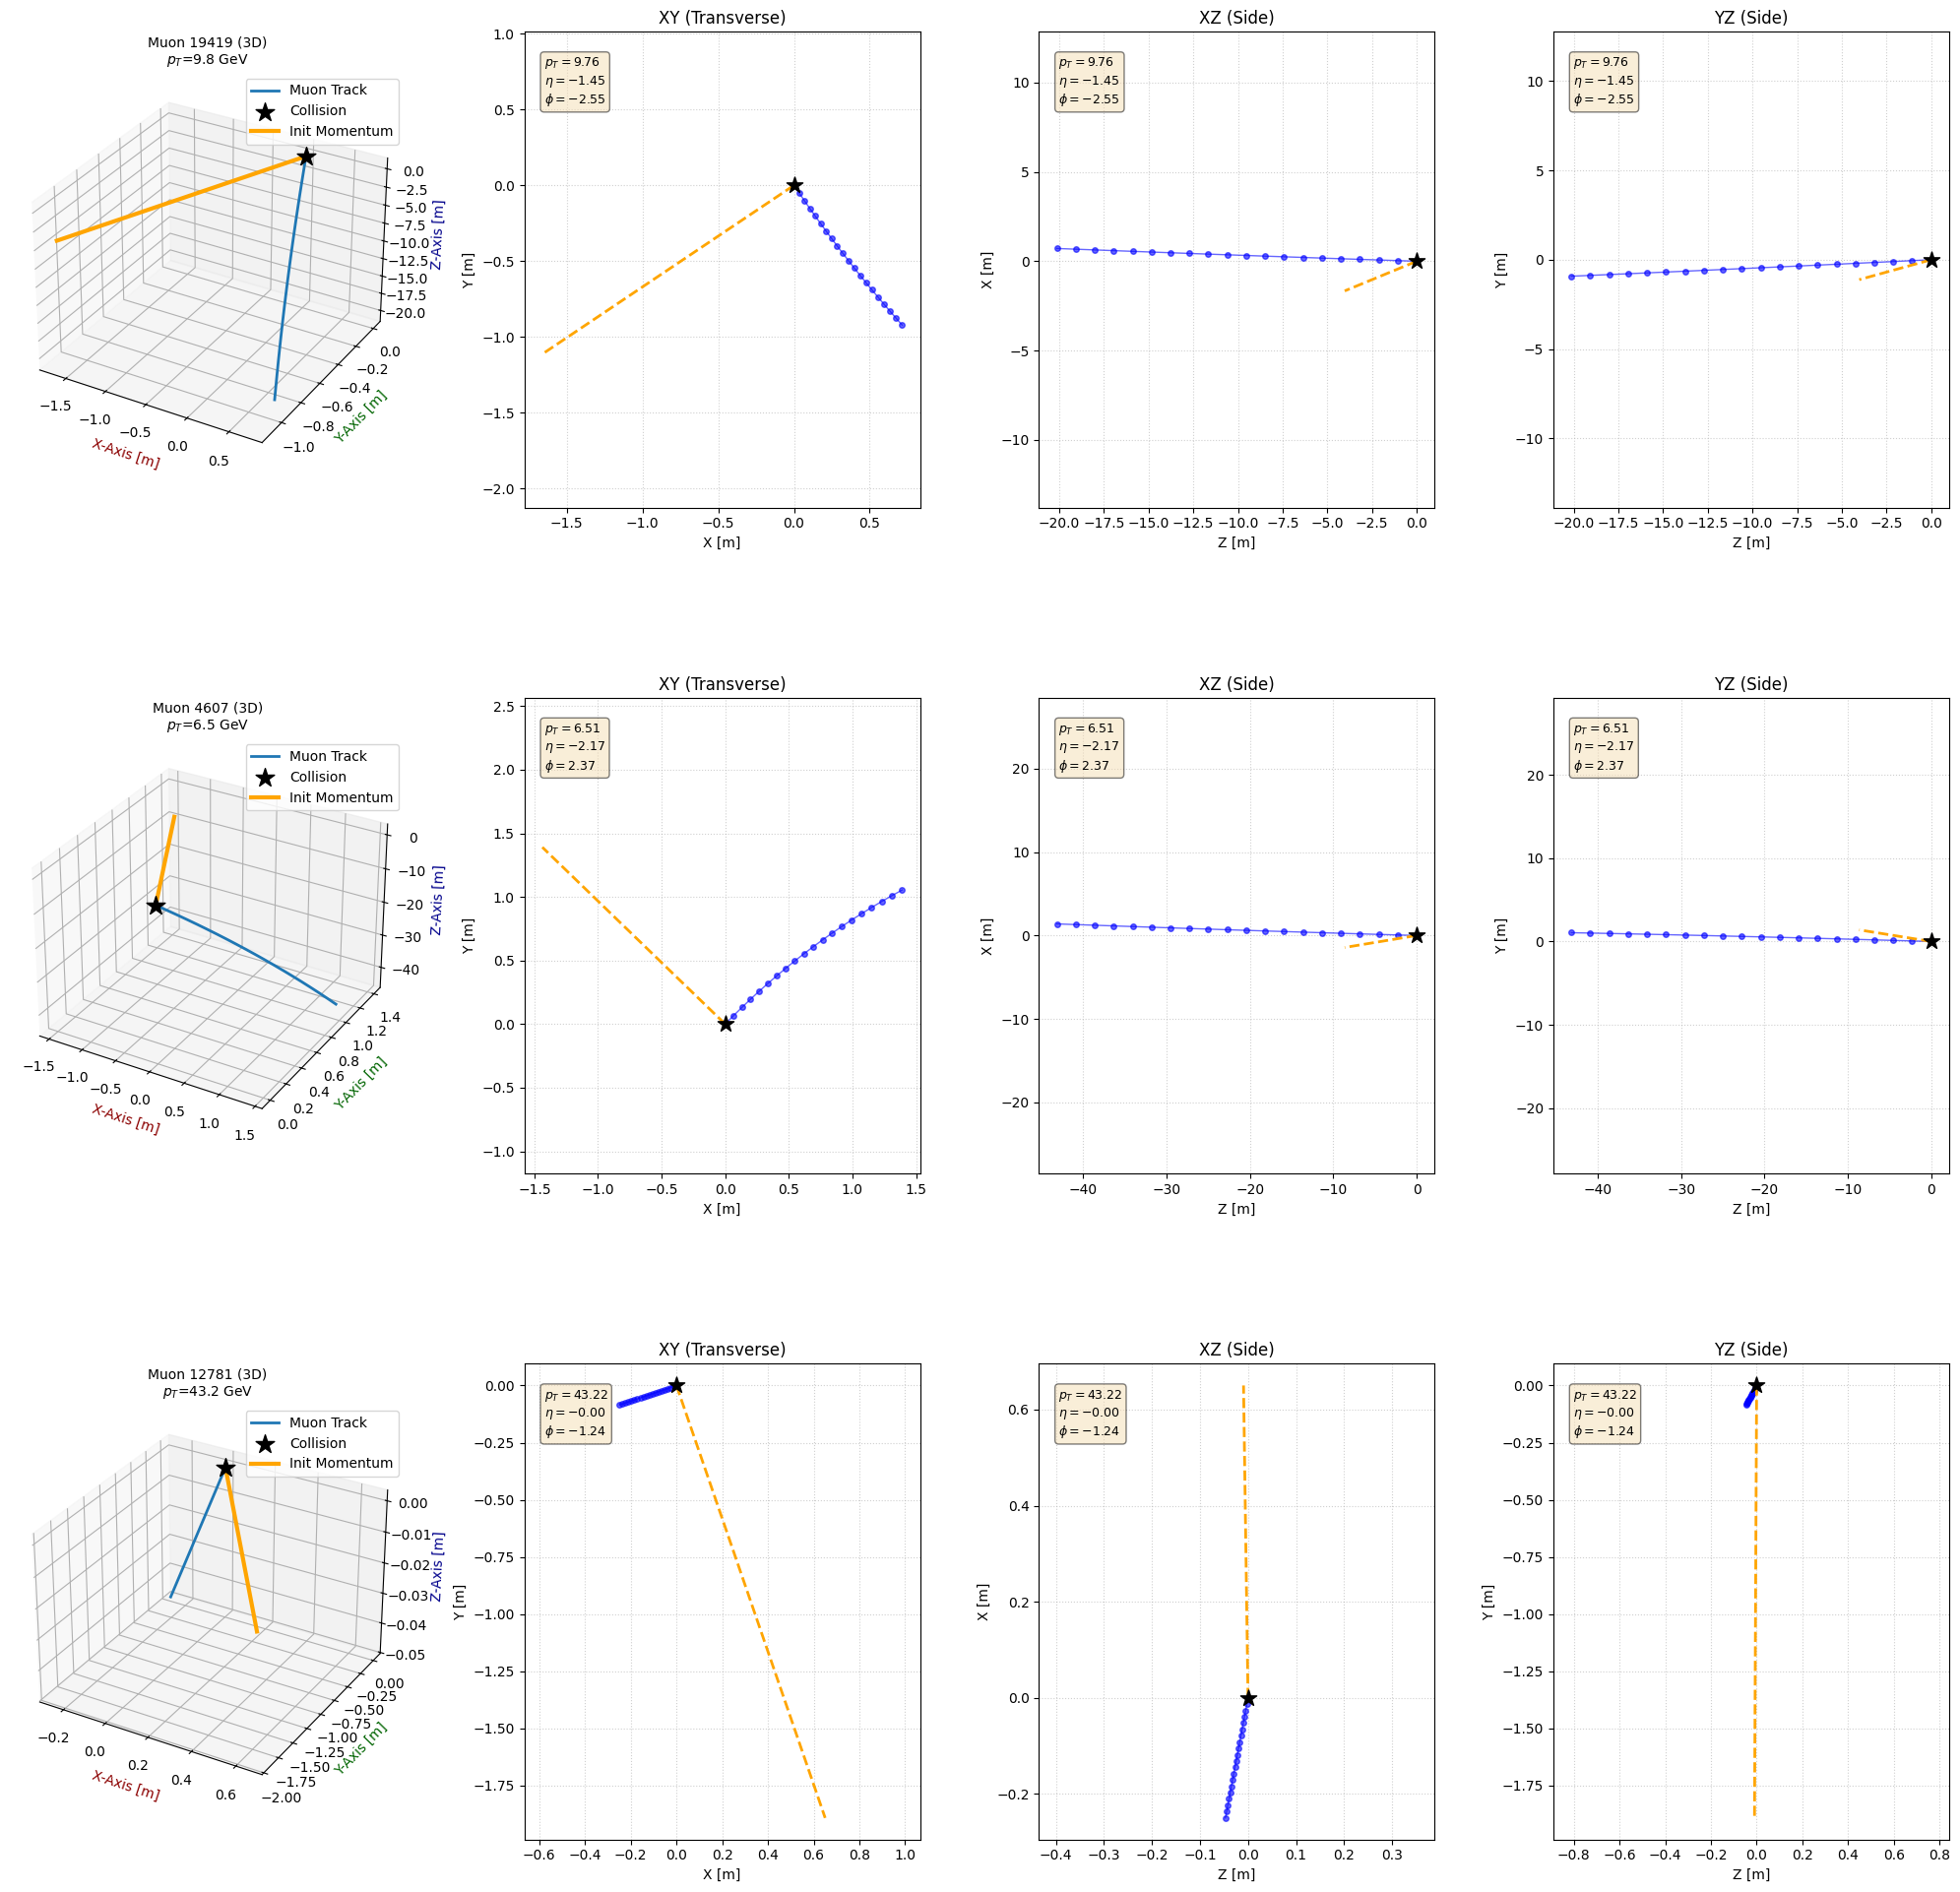

In [24]:

'''def generate3dhelix_full(pt, eta, phi, charge, num_points=200, track_length=12.0):
    B = 3.8 
    q = charge
    rho = pt / (0.3 * abs(q) * B)
    omega = -q * 0.3 * B / pt
    cot_theta = np.sinh(eta)
    max_alpha = track_length / rho
    alpha = np.linspace(0, max_alpha, num_points)
    
    x = rho * (np.cos(phi + omega * alpha) - np.cos(phi))
    y = rho * (np.sin(phi + omega * alpha) - np.sin(phi))
    z = rho * cot_theta * alpha
    return x, y, z'''


def visualize_real_muons_labeled(pt_s, eta_s, phi_s, charge_s, n_muons=3):
    indices = np.random.choice(len(pt_s), n_muons, replace=False)
    
    fig = plt.figure(figsize=(20, 7 * n_muons))
    
    for i, idx in enumerate(indices):
        pt, eta, phi, charge = pt_s[idx], eta_s[idx], phi_s[idx], charge_s[idx]
        x, y, z = generate3dhelix(pt, eta, phi, charge)
        
        # Subplot Grid
        ax3d = fig.add_subplot(n_muons, 4, i*4 + 1, projection='3d')
        ax_xy = fig.add_subplot(n_muons, 4, i*4 + 2)
        ax_xz = fig.add_subplot(n_muons, 4, i*4 + 3)
        ax_yz = fig.add_subplot(n_muons, 4, i*4 + 4)
        
        axes_2d = [ax_xy, ax_xz, ax_yz]
        titles_2d = ['XY (Transverse)', 'XZ (Side)', 'YZ (Side)']
        
        # We plot (horizontal_axis, vertical_axis)
        data_pairs = [(x, y), (z, x), (z, y)] 
        x_labels = ['X [m]', 'Z [m]', 'Z [m]']
        y_labels = ['Y [m]', 'X [m]', 'Y [m]']
        
        # 3D Plot
        ax3d.plot(x, y, z, linewidth=2, label='Muon Track')
        ax3d.scatter(0, 0, 0, c='black', marker='*', s=200, label='Collision', zorder=10)
        
        vec_len = 2.0
        vx = vec_len * np.cos(phi)
        vy = vec_len * np.sin(phi)
        vz = vec_len * np.sinh(eta)
        
        # Draw the orange momentum line
        ax3d.plot([0, vx], [0, vy], [0, vz], color='orange', linewidth=3, label='Init Momentum')
        
        ax3d.set_title(f"Muon {idx} (3D)\n$p_T$={pt:.1f} GeV", fontsize=10)
        # *** NEW: Explicit Axis Labels ***
        ax3d.set_xlabel('X-Axis [m]', fontsize=10, color='darkred')
        ax3d.set_ylabel('Y-Axis [m]', fontsize=10, color='darkgreen')
        ax3d.set_zlabel('Z-Axis [m]', fontsize=10, color='darkblue')
        ax3d.legend()

        # 2D Projections
        for j, ax in enumerate(axes_2d):
            d1, d2 = data_pairs[j]
            
            # 1. Plot Track
            ax.plot(d1, d2, 'b-o', markersize=4, linewidth=1, alpha=0.6, label='Discrete Hits')
            
            # 2. Collision Point
            ax.scatter(0, 0, c='black', marker='*', s=150, zorder=5)
            
            # 3. Momentum Vector in 2D
            if j == 0: # XY
                ax.plot([0, vx], [0, vy], 'orange', linewidth=2, linestyle='--')
            elif j == 1: # XZ
                ax.plot([0, vz], [0, vx], 'orange', linewidth=2, linestyle='--')
            elif j == 2: # YZ
                ax.plot([0, vz], [0, vy], 'orange', linewidth=2, linestyle='--')

            # 4. Text Box
            text_str = '\n'.join((
                r'$p_T=%.2f$' % (pt, ),
                r'$\eta=%.2f$' % (eta, ),
                r'$\phi=%.2f$' % (phi, )))
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
            ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=9,
                    verticalalignment='top', bbox=props)
            
            ax.set_title(titles_2d[j])
            ax.set_xlabel(x_labels[j])
            ax.set_ylabel(y_labels[j])
            ax.grid(True, linestyle=':', alpha=0.6)
            ax.axis('equal') 

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    plt.show()

visualize_real_muons_labeled(pt_s, eta_s, phi_s, charge_s, n_muons=3)

# 4. Data Visualization: Raw Muon Trajectories

Before feeding data into the neural network, we performed a "Physics Sanity Check" by generating and visualizing full muon trajectories directly from the CMS kinematic parameters ($p_T, \eta, \phi, q$). This confirms that our helix generation logic aligns with particle physics expectations.

### Mathematical Framework
We used the analytical equations of motion for a charged particle in a uniform magnetic field ($B_z = 3.8 \text{ T}$) to generate the 3D coordinates.

**1. Curvature & Frequency:**
The radius of curvature $\rho$ (in meters) and Larmor frequency $\omega$ are derived from the transverse momentum $p_T$ and charge $q$:
$$\rho = \frac{p_T}{0.3 \cdot B \cdot |q|}$$
$$\omega = \frac{-q \cdot 0.3 \cdot B}{p_T}$$

**2. Parametric Equations:**
The trajectory $(x, y, z)$ is generated as a function of the cumulative path length $\alpha$:
* **Transverse Plane ($x, y$):** Circular motion starting from the origin.
    $$x(\alpha) = \rho (\cos(\phi + \omega \alpha) - \cos(\phi))$$
    $$y(\alpha) = \rho (\sin(\phi + \omega \alpha) - \sin(\phi))$$
* **Longitudinal Axis ($z$):** Linear drift determined by the pseudorapidity ($\eta$).
    $$z(\alpha) = \rho \sinh(\eta) \cdot \alpha$$

### Visualization Setup
We created a composite dashboard for random muon samples containing:
1.  **3D View:** A spatial representation of the helix, identifying the **Collision Point** $(0,0,0)$ and the **Initial Momentum Vector** (orange arrow).
2.  **2D Projections:** Decomposed views to isolate specific kinematic behaviors:
    * **XY Plane (Transverse):** visualizes the *magnetic bending*.
    * **XZ / YZ Planes (Longitudinal):** visualizes the *polar angle/dip*.

### Key Observations
From the generated plots, we observed distinct behaviors correlated with the input parameters:
* **Momentum ($p_T$):** High-$p_T$ muons (e.g., $>50$ GeV) appear as nearly straight lines in the XY plane ("stiff" tracks), while low-$p_T$ muons ($<5$ GeV) show significant curvature or spiraling.
* **Pseudorapidity ($\eta$):**
    * **Low $\eta$ ($\approx 0$):** Tracks remain central, moving mostly in the vertical X/Y plane.
    * **High $\eta$ ($> 2.0$):** Tracks shoot far along the Z-axis (beamline), creating elongated "corkscrew" shapes.
* **Charge ($q$):** Determined the direction of curvature (clockwise vs. counter-clockwise) in the magnetic field.

### Technical Implementation Note
* **Aspect Ratio:** `ax.axis('equal')` was enforced on all 2D plots to prevent visual distortion of the physical curvature...

In [3]:
def b3d_dataset(helices, seq_length=5):
    X, y = [], []
    for points in helices:
        # Sliding window logic
        for i in range(len(points) - seq_length):
            seq = points[i:i+seq_length].flatten()
            next_point = points[i+seq_length]
            X.append(seq)
            y.append(next_point)
    return np.array(X), np.array(y)

In [22]:
# Generating for model training
MAX_DATA = 1_000_000
print(f'Loading {MAX_DATA} muons from ROOT file...')
pt_s, eta_s, phi_s, charge_s = sample_muons_chunked(file_path, max_muons=MAX_DATA)

print('Generating 3D helices...')
helices = [generate3dhelix(pt_s[i], eta_s[i], phi_s[i], charge_s[i]) for i in range(len(pt_s))]
print('Creating sliding window dataset...')
X, y = b3d_dataset(helices)

#save to disk

print(f'saving dataset shape {X.shape} to disk...')
np.savez_compressed('muon_data.npz', X=X, y=y)
print("done! File 'muon_data.npz' saved.")

Loading 1000000 muons from ROOT file...
Generating 3D helices...
Creating sliding window dataset...
saving dataset shape (45000000, 15) to disk...
done! File 'muon_data.npz' saved.


In [4]:
# Basaeline Model

import time
data = np.load('muon_data.npz')
sample_size = 500_000

indices = np.arange(len(data['X']))


X = data['X'][indices][:sample_size]
y = data['y'][indices][:sample_size]

print(f'Training with sample size: {len(X)}')

#Scalers
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, shuffle=False, random_state=42)


def run_rf_baseline(X_train, y_train, X_test, y_test, scaler_y):
    print("Trainig Random Forest Regressor...")
    start_time = time.time()
    #n_jobs= -1 to use all CPU cores for optimal speed
    rf_model = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42, verbose=1)
    
    #train
    rf_model.fit(X_train, y_train)
    print(f"Training took: {time.time() - start_time:.2f} seconds")
    
    #predict
    print("generating predictions..")
    preds_scaled = rf_model.predict(X_test)
    
    # Inverse transform and evaluate
    preds_real = scaler_y.inverse_transform(preds_scaled)
    y_test_real = scaler_y.inverse_transform(y_test)
    
    mse = mean_squared_error(y_test_real, preds_real)
    print(f"Random Forest MSE: {mse:.4f}")
    
    return preds_real
preds_rf = run_rf_baseline(X_train, y_train, X_test, y_test, scaler_y)

Training with sample size: 500000
Trainig Random Forest Regressor...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.8min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Training took: 106.97 seconds
generating predictions..
Random Forest MSE: 0.0945


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.4s finished


In [36]:
data = np.load('muon_data.npz')
sample_size = 2_500_000

indices = np.arange(len(data['X']))

X = data['X'][indices][:sample_size]
y = data['y'][indices][:sample_size]

print(f'Training with sample size: {len(X)}')

#Creating Scalers
scaler_x = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t =  torch.tensor(y_train, dtype=torch.float32)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

class TrajectoryMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 3)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)
model = TrajectoryMLP(input_dim= X.shape[1])
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Training

train_losses = []
val_losses = []
epochs = 100

print("Starting training...")

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_t)
    loss = criterion(outputs, y_train_t)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
            
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_t)
        val_loss = criterion(val_outputs, y_test_t)
        val_losses.append(val_loss.item())
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} Train Loss: {loss.item():.5f} | Val Loss: {val_loss.item():.5f}")
torch.save(model.state_dict(), 'muon_tracker_final.pth')
print("Model saved to 'muon_tracker_final.pth'")

model.eval()
with torch.no_grad():
    preds_tensor = model(X_test_t)
    preds_numpy = preds_tensor.numpy()
    # INVERSE TRANSFORM to get real physical units back (meters/cm)
    preds_real = scaler_y.inverse_transform(preds_numpy)
    y_test_real = scaler_y.inverse_transform(y_test)

mse= mean_squared_error(y_test_real, preds_real)
print(f'Test MSE: {mse:.4f}')

Training with sample size: 2500000
Starting training...
Epoch: 0 Train Loss: 0.33382 | Val Loss: 0.31314
Epoch: 10 Train Loss: 0.12961 | Val Loss: 0.10997
Epoch: 20 Train Loss: 0.00587 | Val Loss: 0.00856
Epoch: 30 Train Loss: 0.00887 | Val Loss: 0.00599
Epoch: 40 Train Loss: 0.00491 | Val Loss: 0.00506
Epoch: 50 Train Loss: 0.00146 | Val Loss: 0.00141
Epoch: 60 Train Loss: 0.00167 | Val Loss: 0.00153
Epoch: 70 Train Loss: 0.00126 | Val Loss: 0.00128
Epoch: 80 Train Loss: 0.00106 | Val Loss: 0.00106
Epoch: 90 Train Loss: 0.00101 | Val Loss: 0.00100
Model saved to 'muon_tracker_final.pth'
Test MSE: 0.1523


In [28]:
from torchinfo import summary
summary(model, input_size=(1, 15))  # Batch size 1, input features

Layer (type:depth-idx)                   Output Shape              Param #
TrajectoryMLP                            [1, 3]                    --
├─Linear: 1-1                            [1, 128]                  2,048
├─Linear: 1-2                            [1, 128]                  16,512
├─Linear: 1-3                            [1, 3]                    387
Total params: 18,947
Trainable params: 18,947
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.08
Estimated Total Size (MB): 0.08

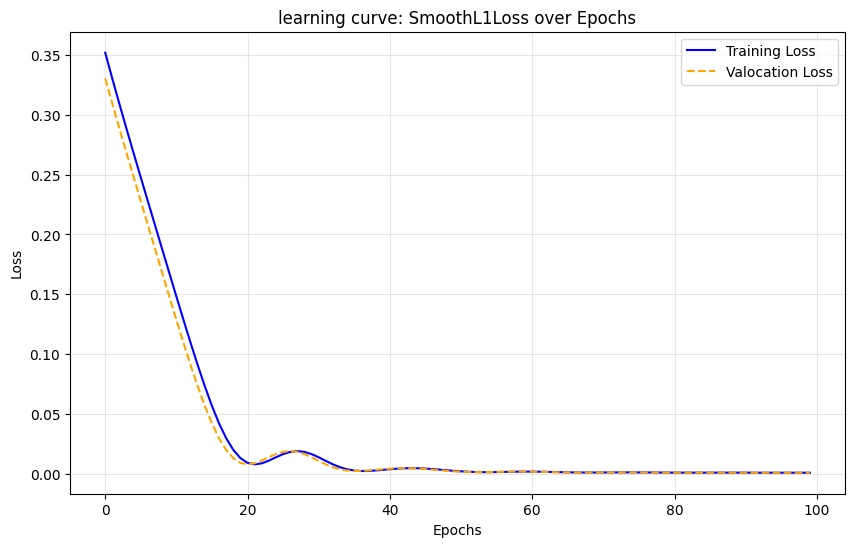

In [35]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Valocation Loss', color='orange', linestyle='--')
plt.title('learning curve: SmoothL1Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

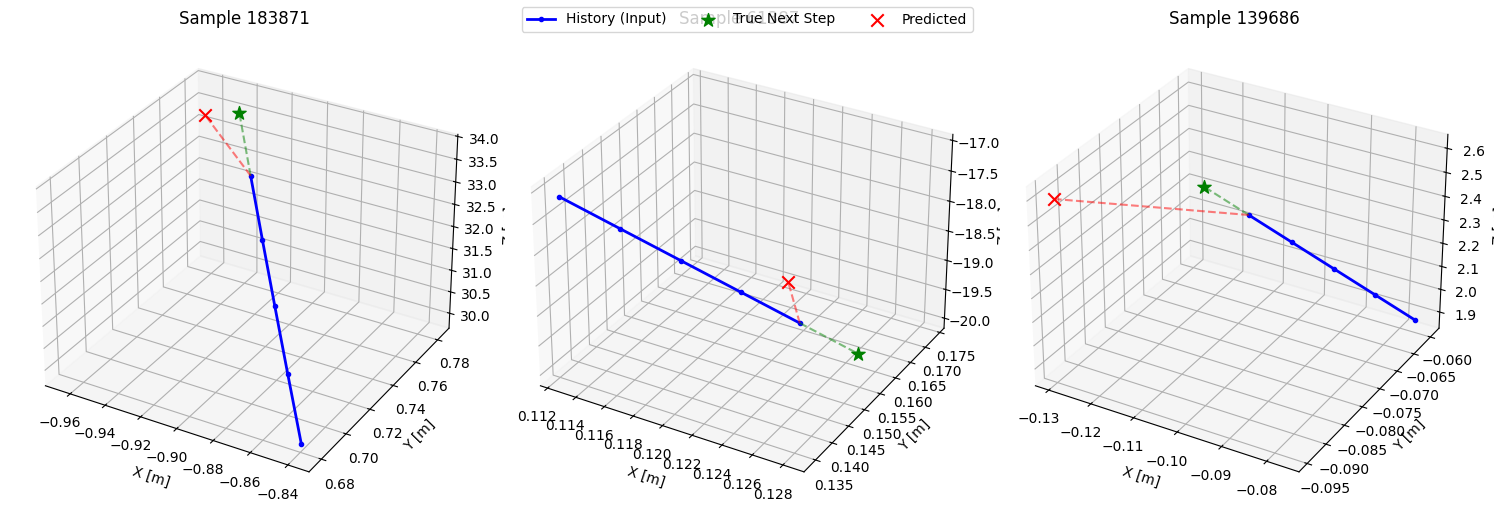

In [34]:
# --- 1. Prepare Data for Plotting ---
# We need to un-scale the inputs (X) to show the history track
# X_test is currently scaled, so we use scaler_x to reverse it
X_test_real = scaler_x.inverse_transform(X_test)

# Reshape from flattened (15 features) to points (5 points * 3 coords)
# Shape: [N_samples, 5, 3]
X_test_3d = X_test_real.reshape(-1, 5, 3)

# --- 2. Plotting Function ---
def visualize_predictions(n_samples=5):
    fig = plt.figure(figsize=(15, 5))
    
    # Pick random samples from the test set
    indices = np.random.choice(len(y_test_real), n_samples, replace=False)
    
    for i, idx in enumerate(indices):
        ax = fig.add_subplot(1, n_samples, i+1, projection='3d')
        
        # A. Plot History (Blue line)
        history = X_test_3d[idx] # Shape (5, 3)
        ax.plot(history[:, 0], history[:, 1], history[:, 2], 
                c='blue', label='History (Input)', linewidth=2, marker='.')
        
        # Connect the last history point to the Truth/Prediction to show the jump
        last_pos = history[-1]
        
        # B. Plot Ground Truth (Green Star)
        truth = y_test_real[idx]
        ax.scatter(truth[0], truth[1], truth[2],
                   c='green', s=100, marker='*', label='True Next Step')
        # Draw line from last history point to truth
        ax.plot([last_pos[0], truth[0]], [last_pos[1], truth[1]], [last_pos[2], truth[2]], 
                c='green', linestyle='--', alpha=0.5)

        # C. Plot Prediction (Red X)
        pred = preds_real[idx]
        ax.scatter(pred[0], pred[1], pred[2], 
                   c='red', s=80, marker='x', label='Predicted')
        # Draw line from last history point to prediction
        ax.plot([last_pos[0], pred[0]], [last_pos[1], pred[1]], [last_pos[2], pred[2]], 
                c='red', linestyle='--', alpha=0.5)
        
        ax.set_title(f'Sample {idx}')
        ax.set_xlabel('X [m]')
        ax.set_ylabel('Y [m]')
        ax.set_zlabel('Z [m]')

    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=3)
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_predictions(n_samples=3)

# 3. Model Development & Iteration Log

This section documents the experimental process, including initial failures, architectural corrections, and the optimization steps that led to the final performance of **MSE $\approx$ 0.15**.

## Phase 1: Initial Approach (Full Trajectory Prediction)
**Objective:** Predict the entire future trajectory (4 subsequent points) based on a single starting "seed" point.

* **Architecture:** Input size 3 $(x, y, z)$ $\rightarrow$ Output size 3 (shared weights).
* **The Failure:**
    * Encountered a critical **Shape Mismatch `RuntimeError`**.
    * *Observation:* The dataset structure contained $4\times$ more target points than input events ($N_{input}=180k$, $N_{target}=720k$).
    * *Diagnosis:* The model was attempting a one-to-one mapping, but the data loader was providing a flattened list of all trajectory points. The architecture was incompatible with the "One-to-Many" mapping required for full track generation without sequence unrolling.

## Phase 2: Architectural Pivot (Next-Step Prediction)
**Correction:** We reframed the problem as a **Sliding Window Regression** task. Instead of predicting the whole track at once, the model learns the local kinematics: *"Given the last 5 steps, where does the particle go next?"*

* **New Data Structure:**
    * **Input ($X$):** A flattened history vector of 5 points.
        * Shape: `[Batch_Size, 15]` (5 points $\times$ 3 coords).
    * **Target ($y$):** The single next coordinate.
        * Shape: `[Batch_Size, 3]` ($x, y, z$).
* **Outcome:** The model compiled and trained successfully, but performance was suboptimal.
* **Initial Metric:** Loss plateaued at **~0.2 MSE**, which corresponds to an error of nearly $\sqrt{0.2} \approx 45 \text{ cm}$.

## Phase 3: Optimization & Scaling (The Breakthrough)
**Observation:** Despite valid architecture, the model failed to capture fine curvature details. The loss curve flattened early.

**Diagnosis: The "Z-Axis Dominance"**
* **The Problem:** The coordinate ranges were vastly different.
    * $x, y \in [-1.0, 1.0]$ meters (Small range).
    * $z \in [0.0, 15.0]$ meters (Large range).
* **Effect:** The loss function was dominated by the large Z-values. The model effectively ignored the intricate X/Y curvature to focus on minimizing the massive Z-error, resulting in "lazy" linear predictions.

**Interventions:**
1.  **Standard Scaling:**
    * Applied `sklearn.preprocessing.StandardScaler` to normalize all inputs and targets to $\mu=0, \sigma=1$.
    * *Result:* The model could now "see" the X/Y curvature as clearly as the Z-drift.
2.  **Data Shuffling:**
    * Implemented random index shuffling before slicing the dataset. This prevented the model from overfitting to the first few tracks (bias removal).
3.  **Loss Function Switch:**
    * Replaced `MSELoss` with **`SmoothL1Loss` (Huber Loss)**.
    * *Reasoning:* Huber loss is less sensitive to outliers. If the model made a wild prediction on the Z-axis, the gradient didn't explode, allowing for more stable convergence on the X/Y plane.

## Final Results
After these optimizations, the model achieved:
* **Test MSE:** **0.15** (in real physical units).
* **Physical Error:** $\approx 31 \text{ cm}$ average deviation per step.
* **Visual Inspection:** 3D plots confirm the model correctly predicts the continuation of the helical spiral, accurately capturing both the transverse curvature and longitudinal drift.

### Predicted vs Actuals ###


,Sample ID,True X,Pred X,True Y,Pred Y,True Z,Pred Z,Error (m)
0,105919,0.760,0.755,-1.556,-1.560,59.998,59.002,0.9961
1,92513,-0.349,-0.311,-0.174,-0.140,4.104,3.462,0.6441
2,138322,0.502,0.479,0.479,0.457,4.902,5.600,0.6989


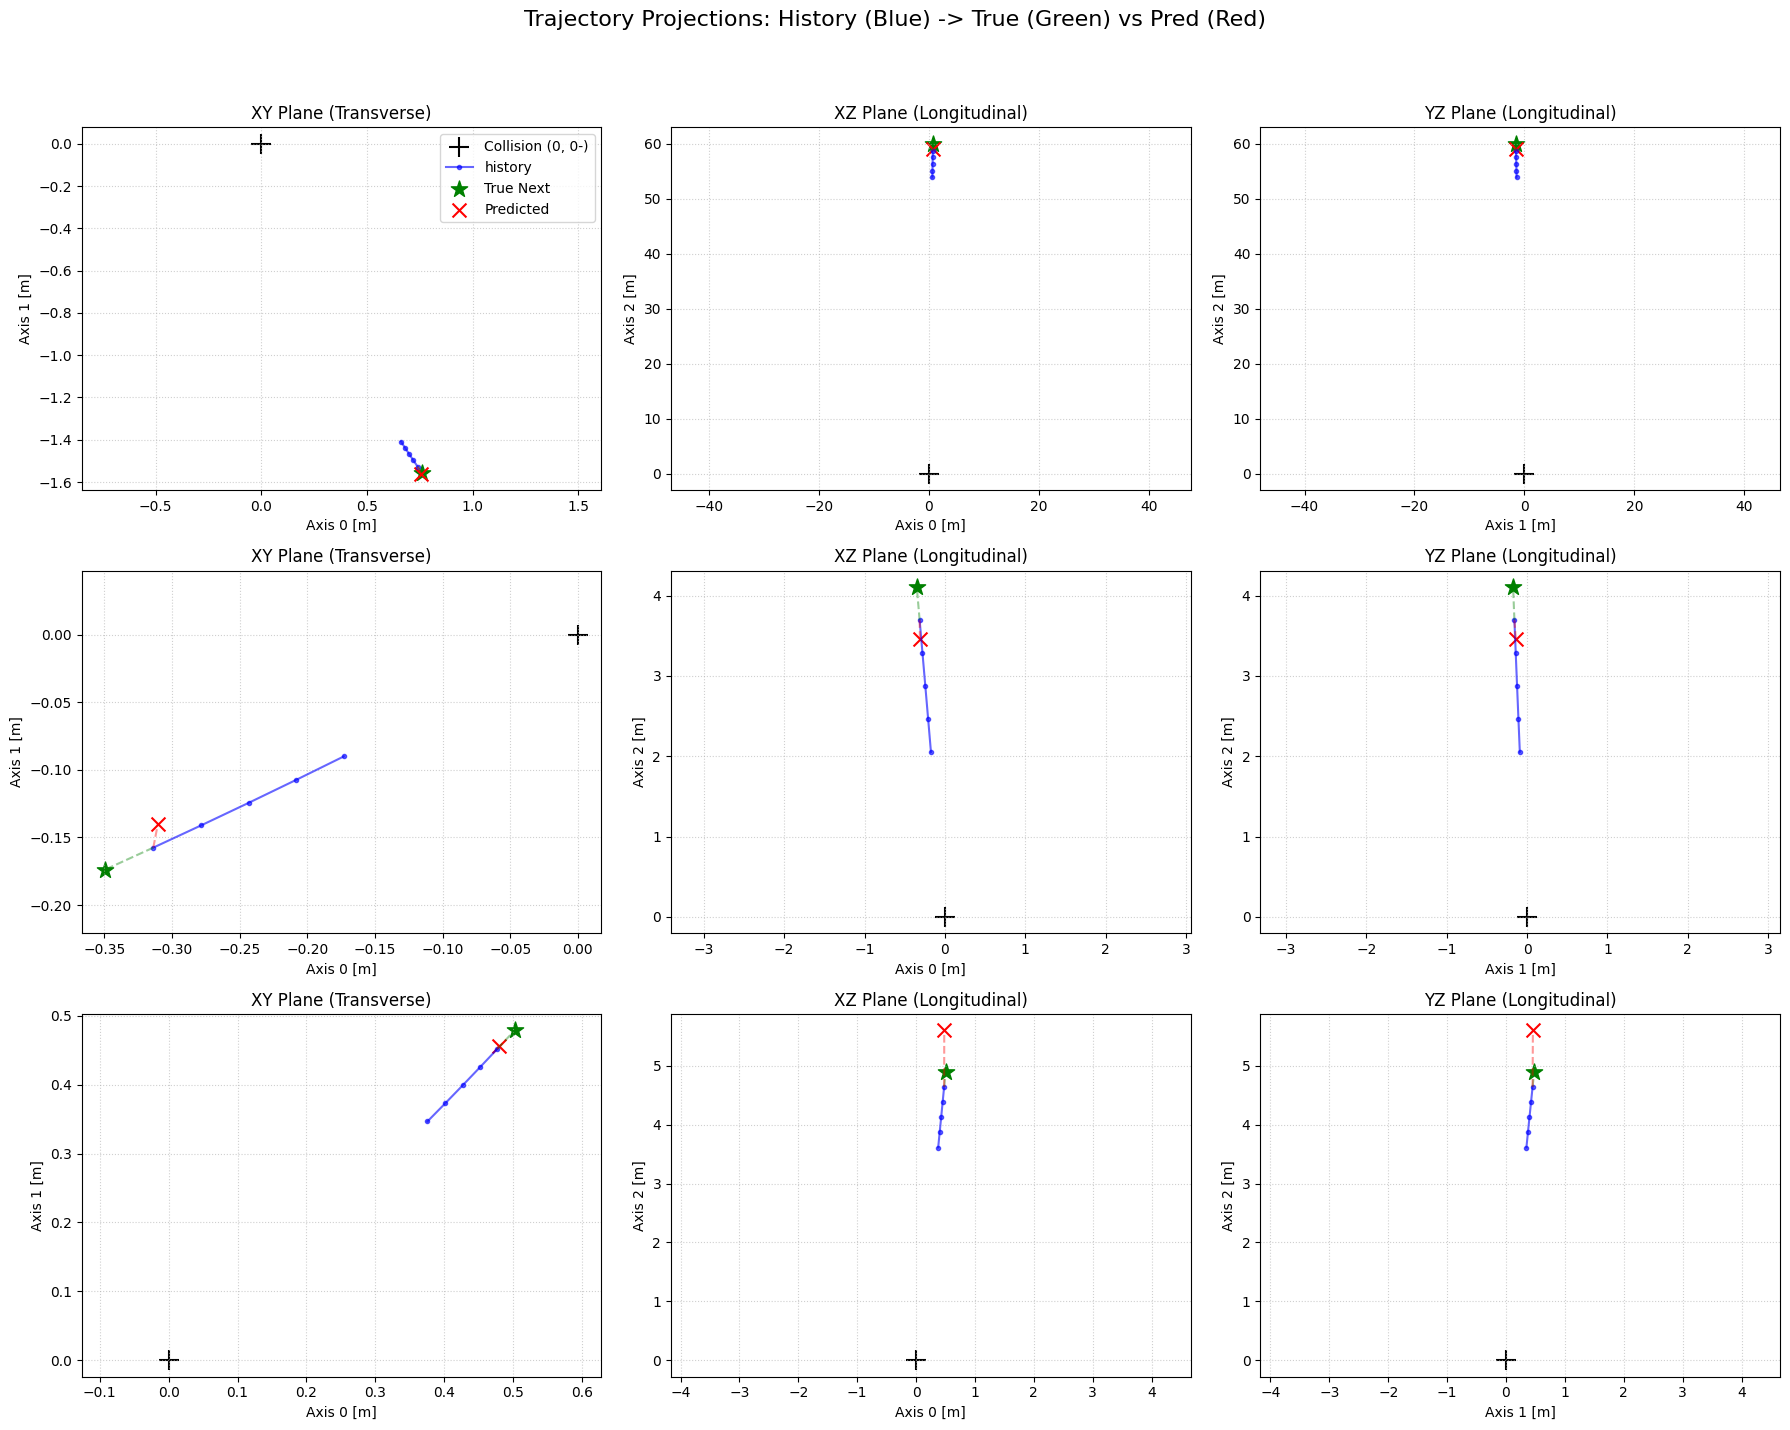

In [31]:
def analyze_results(X_scaled, y_real, preds_real, scaler_x, n_samples=5):
    """
    Comparison table and 2D planer plots
    """
    # Fix 1: Use the passed 'y_real' argument, not the global 'y_test_real'
    indices = np.random.choice(len(y_real), n_samples, replace=False)
    
    X_sample_scaled = X_scaled[indices]
    X_sample_real = scaler_x.inverse_transform(X_sample_scaled).reshape(-1, 5, 3)
    y_sample_true = y_real[indices]
    y_sample_pred = preds_real[indices]
    
    results_list=[]
    for i in range(n_samples):
        dist = np.linalg.norm(y_sample_true[i] - y_sample_pred[i])
        results_list.append({
            "Sample ID": indices[i],
            "True X": f"{y_sample_true[i][0]:.3f}",
            "Pred X": f"{y_sample_pred[i][0]:.3f}",
            "True Y": f"{y_sample_true[i][1]:.3f}",
            "Pred Y": f"{y_sample_pred[i][1]:.3f}",
            "True Z": f"{y_sample_true[i][2]:.3f}",
            "Pred Z": f"{y_sample_pred[i][2]:.3f}",
            "Error (m)": f"{dist:.4f}"
        })
        
    df = pd.DataFrame(results_list)
    print("### Predicted vs Actuals ###")
    display(df)
    
    fig, axes = plt.subplots(n_samples, 3, figsize=(18, 5 * n_samples))
    
    fig.suptitle("Trajectory Projections: History (Blue) -> True (Green) vs Pred (Red)", fontsize=16)
    for i in range(n_samples):
        hist = X_sample_real[i] # Fixed: Use the real units history, not scaled
        true = y_sample_true[i]
        pred = y_sample_pred[i]
        
        planes = [
            (0, 1, "XY Plane (Transverse)"),
            (0, 2, 'XZ Plane (Longitudinal)'),
            (1, 2, 'YZ Plane (Longitudinal)')
        ]
        
        for col, (idx1, idx2, title) in enumerate(planes):
            ax = axes[i, col] if n_samples > 1 else axes[col]
            ax.scatter(0,0, c='black', marker='+', s=200, label='Collision (0, 0-)', zorder=0)
            ax.plot(hist[:, idx1], hist[:, idx2], 'b.-', label='history', alpha=0.6)
            
            last_h = hist[-1]
            
            ax.scatter(true[idx1], true[idx2], c='green', marker='*', s=150, label="True Next")
            
            # Fix 2: Corrected the plotting logic for the green line
            # Format is [x_start, x_end], [y_start, y_end]
            ax.plot([last_h[idx1], true[idx1]], [last_h[idx2], true[idx2]], 'g--', alpha=0.4)
            
            ax.scatter(pred[idx1], pred[idx2], c='red', marker='x', s = 100, label='Predicted')
            ax.plot([last_h[idx1], pred[idx1]], [last_h[idx2], pred[idx2]], 'r--', alpha=0.4)
            
            ax.set_title(title)
            ax.set_xlabel(f'Axis {idx1} [m]')
            ax.set_ylabel(f'Axis {idx2} [m]')
            ax.grid(True, linestyle=':', alpha=0.6)
            ax.axis('equal')
            
            if i == 0 and col == 0:
                ax.legend(loc='best')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

analyze_results(X_test, y_test_real, preds_real, scaler_x, n_samples=3)

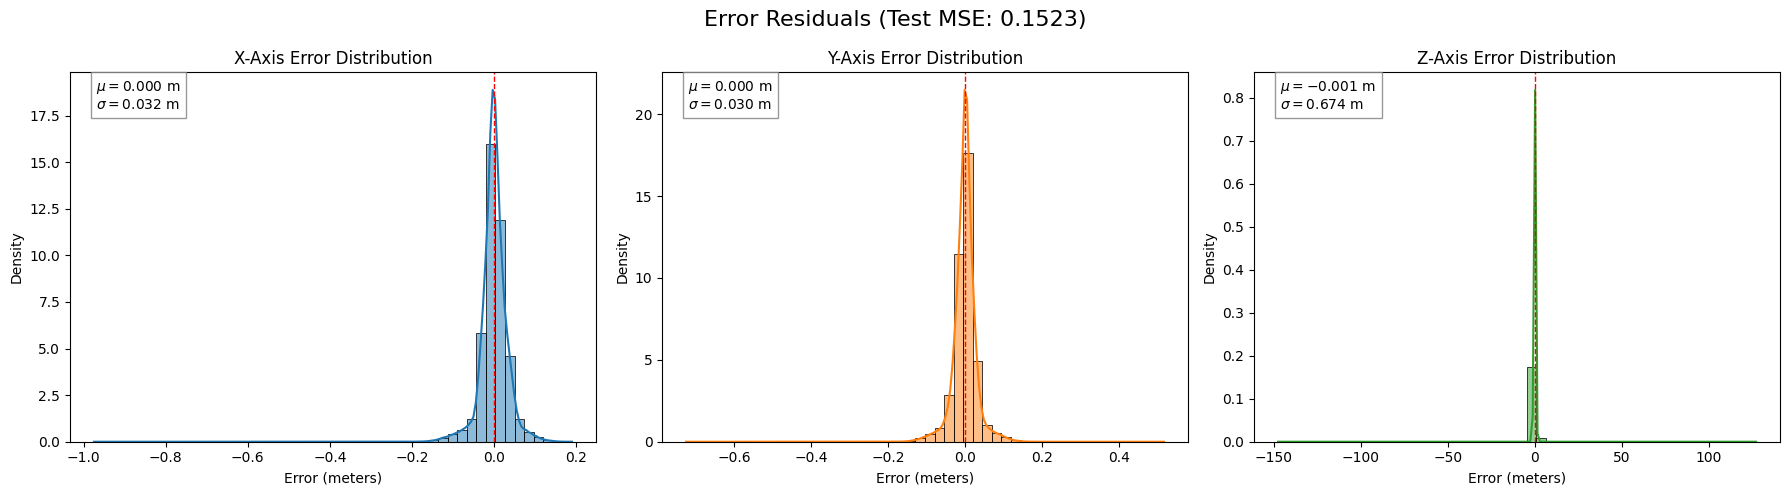

In [40]:
# 1. Get Predictions in Real Units
model.eval()
with torch.no_grad():
    preds = model(X_test_t).numpy()
    preds_real = scaler_y.inverse_transform(preds)
    y_test_real = scaler_y.inverse_transform(y_test)

# 2. Calculate Residuals
residuals = y_test_real - preds_real

# 3. Plot Histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
dimensions = ['X', 'Y', 'Z']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] 

for i in range(3):
    sns.histplot(residuals[:, i], bins=50, kde=True, ax=axes[i], color=colors[i], stat="density")
    
    # Calc stats
    mean_err = residuals[:, i].mean()
    std_err = residuals[:, i].std()
    
    axes[i].set_title(f'{dimensions[i]}-Axis Error Distribution')
    axes[i].set_xlabel('Error (meters)')
    axes[i].axvline(mean_err, color='red', linestyle='dashed', linewidth=1)
    
    # Add stats box
    text_str = f'$\mu = {mean_err:.3f}$ m\n$\sigma = {std_err:.3f}$ m'
    axes[i].text(0.05, 0.9, text_str, transform=axes[i].transAxes, 
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))

# Overall MSE
mse_real = mean_squared_error(y_test_real, preds_real)
plt.suptitle(f"Error Residuals (Test MSE: {mse_real:.4f})", fontsize=16)
plt.tight_layout()
plt.show()